# GrandPrix Results Script

This notebooks races a set of controllers in the folder Downloads/grandprix and then creates a movie of the race.

In [1]:
import glob
import os
import importlib
import sys
from grandprix import Sim
import numpy as np
import matplotlib.pyplot as plt
from contextlib import redirect_stdout
import io
%matplotlib inline


def race(seed, race_name, print_failures=False):
    home=os.environ['HOME']
    path=os.path.join(home, "Downloads/grandprix")
    sys.path.insert(0, path)
    os.chdir(path)

    results = []
    data = {}
    modules = glob.glob("*.py")
    for i, f in enumerate(modules):
        if i % 10 == 0:
            print("{:4.0f} % complete".format(100*i/len(modules)))
        mod_name = f.split('.')[0]
        np.random.seed(seed)
        try:
            # set a trap and redirect stdout
            trap = io.StringIO()
            with redirect_stdout(trap):
                mod = importlib.import_module(mod_name)
                sim = Sim(mod.Controller)
                dist = sim.run()
                name = f.split('_')[1]
                results.append({
                    'name': name,
                    'dist': dist})
                data[name] = sim.data
        except Exception as e:
            if print_failures:
                print("{:s} failed with: {:s}".format(mod_name, str(e)))

    results = sorted(results, key=lambda x: x['dist'], reverse=True)

    place = 1
    j = 0
    while j < len(results):
        tie_count = 1
        i = 0
        while j + i + 1 < len(results):
            if results[j + i]['dist'] == results[j + i  + 1]['dist']:
                tie_count += 1
                i += 1
            else:
                break
        if tie_count > 1:
            for i in range(tie_count):
                results[j + i]['place'] = int(place + tie_count/2)
            j += tie_count
            place += tie_count
        else:
            results[j]['place'] = place
            place += 1
            j += 1

    n = len(results)
    for r in results:
        if r['place'] <= 0.25*n:
            r['points'] = 4
        elif r['place'] <= 0.5*n:
            r['points'] = 3
        elif r['place'] <= 0.75*n:
            r['points'] = 2
        else:
            r['points'] = 1

    with open('grandprix_{:s}.txt'.format(race_name), 'w') as f:
        for r in results:
            f.write("place: {:4d}\tpoints: {:4d}"
                    "\tname: {:15s}\tdistance: {:10.3f} m\n".format(
                r['place'], r['points'], r['name'], r['dist']))

    with open('grandprix_anon_{:s}.txt'.format(race_name), 'w') as f:
        for r in results:
            f.write("place: {:4d}\tpoints: {:4d}"
                    "\tdistance: {:10.3f} m\n".format(
                r['place'], r['points'], r['dist']))

    plt.figure(figsize=(10, 10))
    d = data[results[0]['name']]
    plt.plot(d['track_left_x'], d['track_left_y'], 'k', linewidth=1)
    plt.plot(d['track_right_x'], d['track_right_y'], 'k', linewidth=1)
    plt.grid()
    place_last = 0
    for r in reversed(results):
        if r['place'] == place_last:
            continue
        else:
            place_last = r['place']
        d = data[r['name']]
        if r['place'] > 3:
            alpha = 0.1
        else:
            alpha = 0.9
        plt.plot(d['x'], d['y'], linewidth=2, alpha=alpha)
    plt.title('Grand Prix {:s}'.format(race_name))
    plt.xlabel('x, m')
    plt.ylabel('y, m')
    plt.savefig('{:s}.png'.format(race_name))
    return results, data

   0 % complete
  16 % complete
  32 % complete
  48 % complete
  65 % complete
  81 % complete
  97 % complete


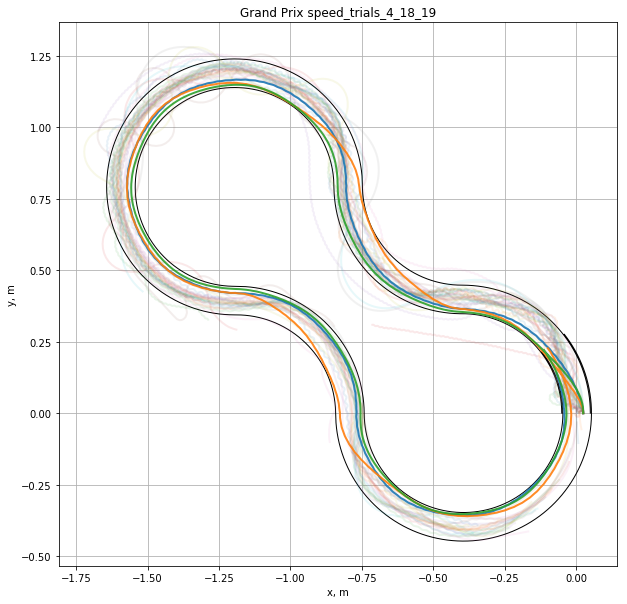

In [2]:
race_name = "speed_trials_4_18_19"
# print_failures will show errors for controllers that do not run
results, data = race(7532, race_name, print_failures=False);

In [3]:
def make_movie(race_name, results, data):
    from matplotlib import animation, rc
    # First set up the figure, the axis, and the plot element we want to animate

    fig = plt.figure(figsize=(10, 10))
    ax = plt.gca()
    interval = 10
    plt.axis('off')
    #ax.set_xlim(( -1.75, 0.25))
    #ax.set_ylim((-0.5, 1.25))

    d = {
        'track_left_x': data[results[0]['name']]['track_left_x'],
        'track_left_y': data[results[0]['name']]['track_left_y'],
        'track_right_x': data[results[0]['name']]['track_right_x'],
        'track_right_y': data[results[0]['name']]['track_right_y'],
        'x': [],
        'y': []
    }

    for k in data.keys():
        d['x'].append(data[k]['x'])
        d['y'].append(data[k]['y'])
    for k in d.keys():
        d[k] = np.array(d[k]).T

    cars_line = []
    cars_dot = []
    place_last = 0
    for r in reversed(results):
        car_line, = ax.plot([], [], '-', alpha=0.1)
        car_dot, = ax.plot([], [], 'X', markersize=10, color=car_line.get_color(), alpha=1)
        cars_line.append(car_line)
        cars_dot.append(car_dot)

    line2, = ax.plot(d['track_left_x'], d['track_left_y'], 'k', lw=2)
    line3, = ax.plot(d['track_right_x'], d['track_right_y'], 'k', lw=2)

    # initialization function: plot the background of each frame
    def init():
        return (line2, line3)

    # animation function. This is called sequentially
    def animate(i):
        j = i*interval
        if j > len(d['x']) - 1:
            j = len(d['x']) - 1
        j0 = j-1000
        if j0 < 0:
            j0 = 0
        for i, (car_line, car_dot) in enumerate(zip(cars_line, cars_dot)):
            car_line.set_data(d['x'][j0:j, i], d['y'][j0:j, i])
            car_dot.set_data(d['x'][j, i], d['y'][j, i])
        return ()

    n = d['x'].shape[0]
    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=n//interval + 10, interval=10*interval, blit=True)
    anim.save(race_name + '.mp4')
    plt.close()
    return anim
anim = make_movie(race_name, results, data)

In [4]:
from IPython.display import HTML
HTML(anim.to_html5_video())

In [6]:
!cat /home/jgoppert/Downloads/grandprix/grandprix_anon_speed_trials_4_18_19.txt

place:    1	points:    4	distance:      5.264 m
place:    2	points:    4	distance:      5.260 m
place:    3	points:    4	distance:      5.164 m
place:    4	points:    4	distance:      5.156 m
place:    6	points:    4	distance:      5.128 m
place:    6	points:    4	distance:      5.128 m
place:    7	points:    4	distance:      5.120 m
place:    8	points:    4	distance:      5.082 m
place:    9	points:    4	distance:      4.968 m
place:   10	points:    4	distance:      4.872 m
place:   12	points:    4	distance:      4.828 m
place:   12	points:    4	distance:      4.828 m
place:   13	points:    4	distance:      4.760 m
place:   14	points:    4	distance:      4.718 m
place:   15	points:    3	distance:      4.684 m
place:   16	points:    3	distance:      4.642 m
place:   17	points:    3	distance:      4.636 m
place:   18	points:    3	distance:      4.632 m
place:   19	points:    3	distance:      4.584 m
place:   20	points:    3	distance:      4.572 m
place:   21	points:    3	distance:      